# Adaptive Velocity Control

In [12]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import importlib
from PIL import Image

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
sys.path.append(os.path.join(sys.path[0], '../data'))

# objects for controlling thruster to minimize transport cost 
import AdaptiveVelocityController

def reload_modules():
    importlib.reload(AdaptiveVelocityController)
print('Done!')

Done!


---
## Propulsion Models

In [61]:
DEG_TO_RAD       = np.pi/180
HOURS_TO_SECONDS = 60*60


def get_prop_power(v):
    '''Determines propulsive power needed to achieve through-water speed v, old model.
    '''
    c1 = 0.450 
    c2 = 0.385
    return((v/c1)**(1/c2))


def get_controller_power(prop_power):
    '''Determines motor controller loss as a function of input controller power
    '''
    c1 = 0.10 
    c0 = 0.32
    return(prop_power*c1 + c0)


def get_thruster_power(v):
    '''Determine total thruster power as sum of propellor power and controller power
    '''
    p_prop = get_prop_power(v)
    p_controller = get_controller_power(p_prop)
    return(p_prop + p_controller)


def get_opt_v(v_list, c, d, h, E, model_num=1):
    """Return optimal velocity from list of velocities given other operating conditions. 
    
    Args:
        v_list: list of possible velocity values to choose from 
        c: ocean current speed (magnitude)
        d: angle of ocean current relative to glider heading (heading of travel)
        h: hotel load of the vehicle 
        E: energy capacity of the vehicle (used for computing range)
        model_num: the glider efficiency model to use in the computation
    """
    r_list  = [get_range(g, c, d, h, E) for g in v_list]
    max_idx = np.nanargmax(r_list)
    max_r   = r_list[max_idx]
    opt_v   = v_list[max_idx]
    return(opt_v)


def get_range(v_g, v_c, delta, p_hotel, E, pitch=12, depth_band=500):
    """Computes the range that can be achieved given the state variables.
    
    Args: 
        i: input current in [Amps]
        v_current: ocean current speed magnitude in [m/s]
        delta: angle between heading and v_current [rad]
        hotel: all non-propulsive power [Amps]
        E: total energy capacity [Amp-Hours]
        pitch: pitch angle of glider [deg]
        depth_band: depth band of the glider [m]
        model_num: the glider efficiency model to use in the computation
    """
    v_c_para    =  v_c*np.cos(delta)
    v_c_perp    =  np.abs(v_c*np.sin(delta))
    
    # glider cannot overcome side-slipe ocean current 
    if v_g < v_c_perp:
        return(np.NaN)
    
    # glider cannot overcome adverse parallel currents
    v_para  = (v_g**2 - v_c_perp**2)**0.5
    if v_para < -v_c_para:
        return(np.NaN)
    
    # glider can succesfully move in intended direction
    # get propulsive power for given velocity using appropriate model
    v_total     = v_para + v_c_para
    p_thruster  = get_thruster_power(v_g)
    p_total     = p_thruster + p_hotel
    t_total = (E*HOURS_TO_SECONDS)/(p_total)
    return (v_total*t_total)

---
## Keep track of Propulsive Model Information

In [14]:
# def get_prop_power_zero(v):
#     '''Determines propulsive power needed to achieve through-water speed v, zero condition new model.
#     '''
#     vmin = 0.1
#     vmax = 1.5
#     v = max(min(v, vmax), vmin)
#     c3 =  5.2454
#     c2 = -2.3848
#     c1 =  3.7921
#     return(c3*v**3 + c2*v**2 + c1*v)


# def get_prop_power(v):
#     '''Determines propulsive power needed to achieve through-water speed v, new model.
#     '''
#     vmin = 0.0
#     vmax = 1.5
#     v = max(min(v, vmax), vmin)
#     c3 =  3.7856
#     c2 =  1.9944
#     c1 = -0.2221
#     c0 =  1.0948
#     return(c3*v**3 + c2*v**2 + c1*v + c0)


# PROP_MODELS = {
#     1 : {
#         'text'  : r"$w(v) = (\frac{v}{0.45})^{2.597}$",
#         'model' : get_prop_power_old
#     },
#     2 : {
#         'text'  : r"$w(v) = 5.25v^3 - 2.38v^2 + 3.79v$",
#         'model' : get_prop_power_zero
#     },
#     3 : {
#         'text'  : r"$P_{prop}(v_{tw}) = 3.79v_{tw}^3 + 1.99v_{tw}^2 - 0.22v_{tw} + 1.09$",
#         'model' : get_prop_power
#     }
# }

---
## 1D Case: Varying Ocean Currents

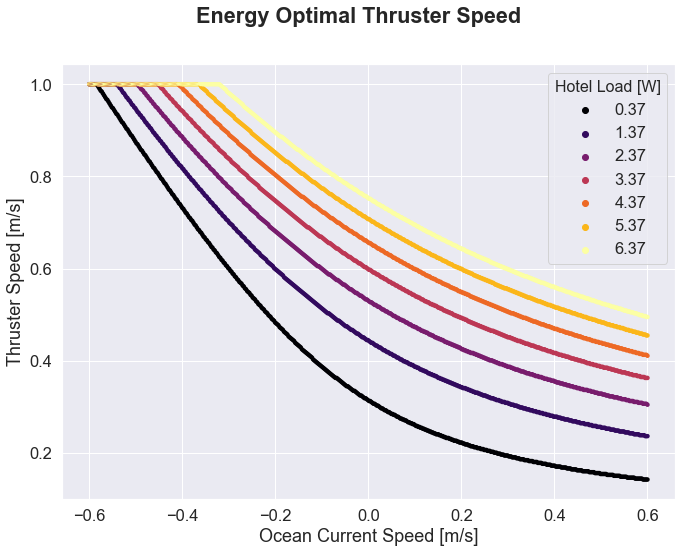

In [140]:
reload_modules()
# Constants 
hotel_transit = 0.37
hotel_survey  = 6.37
E      = 3000
v_max  = 1.0
c_max  = 0.6
res    = 500
# res    = 200
v_list = np.linspace(0, v_max, res)
c_list = np.linspace(-c_max,c_max,res)
# h_list = np.linspace(1,13,7)
h_list = np.around(np.linspace(0.37, 6.37, 7), decimals=2)
delta  = 0
opt_c  = []
opt_v  = []
opt_h  = []

# Get optimal speed values 
for c in c_list:
    for h in h_list:
        opt_v.append(
            AdaptiveVelocityController.AVC.get_optimal_vtw_prop(
            voc_mag=c, 
            voc_delta=delta, 
            p_hotel=h, 
            pitch=0, 
            z_dive=0, 
            z_climb=0, 
            percent_ballast=0.00)
            )
        opt_h.append(h)
        opt_c.append(c)

# get transit and survey lists
transit = []
survey  = []    
for c in c_list:
    transit.append(
        AdaptiveVelocityController.AVC.get_optimal_vtw_prop(
            voc_mag=c, 
            voc_delta=delta, 
            p_hotel=hotel_transit, 
            pitch=0, 
            z_dive=500, 
            z_climb=0, 
            percent_ballast=1.00)
    )
    survey.append(
        AdaptiveVelocityController.AVC.get_optimal_vtw_prop(
            voc_mag=c, 
            voc_delta=delta, 
            p_hotel=hotel_survey, 
            pitch=0, 
            z_dive=500, 
            z_climb=0, 
            percent_ballast=1.00)
    )
                   
# Plotting 
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(11,8))
# sns.scatterplot(c_list, transit, color='darkviolet', s=60, linewidth=0, label='Transit')
# sns.scatterplot(c_list, survey,  color='tab:orange', s=60, linewidth=0, label='Survey')
sns.scatterplot(opt_c, opt_v, opt_h, s=20, palette='inferno', linewidth=0, legend='full')
plt.xlabel('Ocean Current Speed [m/s]')
plt.ylabel('Thruster Speed [m/s]')
plt.legend(title='Hotel Load [W]', title_fontsize=16)
plt.suptitle('Energy Optimal Thruster Speed', fontweight='bold')
plt.savefig('/Users/zduguid/Desktop/tmp/tmp.png')
# plt.savefig('/Users/zduguid/Documents/MIT-WHOI/fig/tmp.png')

---
## 1D Case: Varying Hotel Load (no ocean currents)

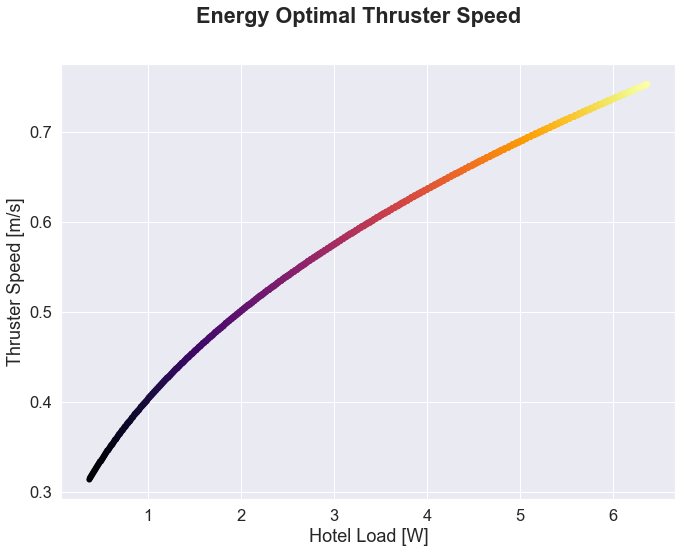

In [45]:
reload_modules()
# Constants
hotel_transit = 0.37
hotel_survey  = 6.37
E      = 3000
# v_max  = 1.5
v_max  = 1.0
h_max  = 10
delta  = 0
c      = 0
res    = 1000
v_list = np.linspace(0, v_max, res)
h_list = np.linspace(hotel_transit, hotel_survey, res)
opt_3  = []

# Get optimal values 
for h in h_list:
    # new prop model
    opt_3.append(
        AdaptiveVelocityController.AVC.get_optimal_vtw_prop(
            voc_mag=c, 
            voc_delta=delta, 
            p_hotel=h, 
            pitch=0, 
            z_dive=0, 
            z_climb=0, 
            percent_ballast=0.00)
    )

# Plotting
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(11,8))
sns.scatterplot(h_list, opt_3, h_list, palette='inferno', linewidth=0, legend=False)
transit = 0.37
survey = 6.37
width = 0.05
alpha = 0.5
# plt.axvspan(transit - width, transit + width, alpha=alpha, color='tab:orange', label='Transit Mode = 0.37W')
# plt.axvspan(survey - width,  survey + width, alpha=alpha, color='tab:green', label='Survey Mode = 6.37W')
# plt.legend(framealpha=1)
plt.xlabel('Hotel Load [W]')
plt.ylabel('Thruster Speed [m/s]')
plt.suptitle('Energy Optimal Thruster Speed', fontweight='bold')
plt.savefig('/Users/zduguid/Desktop/tmp/figure4-A.png')
# plt.savefig('/Users/zduguid/Documents/MIT-WHOI/fig/tmp.png')

(-1.0, 1.0)

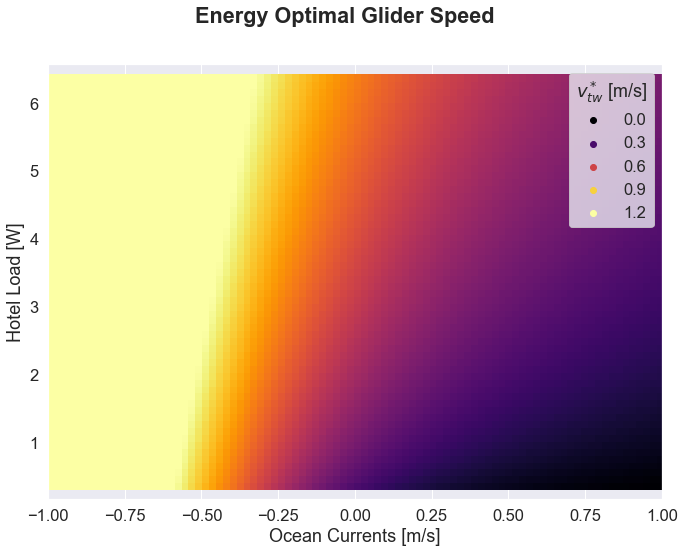

In [48]:
# pick battery configuration
E = 3000
E = 10000

# other plotting parameters
# v_max  = 1.5 
v_max  = 1.0
h_max  = 15
d      = 0
c      = 0
res    = 300
factor = 10
c_max  = 0.999
v_list = np.linspace(0, v_max, 100)
h_list = np.linspace(0.37, 6.37, 6*factor)
c_list = np.linspace(-c_max, c_max, 9*factor)

h_matrix = []
c_matrix = []
v_matrix = [] 


legend_pos = 'lower left'
suptitle='Energy Optimal Glider Speed'
title='Hotel = %.2fW' % (h)

for h in h_list: 
    for c in c_list:
        opt_v  = AdaptiveVelocityController.AVC.get_optimal_vtw_prop(
                    voc_mag=c, 
                    voc_delta=d, 
                    p_hotel=h, 
                    pitch=0, 
                    z_dive=0, 
                    z_climb=0, 
                    percent_ballast=0.00)
        h_matrix.append(h)
        c_matrix.append(c)
        v_matrix.append(opt_v)

# Plotting
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(11,8))
sns.scatterplot(
        c_matrix,
        h_matrix,
        v_matrix,
        palette='inferno',
        linewidth=0,
        marker='s',
        s=80,
)


plt.xlabel('Ocean Currents [m/s]')
plt.ylabel('Hotel Load [W]')
plt.legend(title=r"$v_{tw}^*$ [m/s]")
plt.suptitle(suptitle, fontweight='bold')
plt.ylim([0.17, 6.57])
plt.xlim([-1.0, 1.0])
# plt.savefig('/Users/zduguid/Desktop/tmp/figure-tmp.png')
# plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')

In [ ]:
# pick glider efficiency model
MODEL_NUM = 1 # old model
# MODEL_NUM = 2 # zero-condition new model
# MODEL_NUM = 3 # most accurate model

# pick variable to plot 
PLOT_VAR = 'hotel'
PLOT_VAR = 'currents'

# pick battery configuration
E = 3000
E = 10000

# pick hotel configuration 
h = 0.37
h = 6.37

# other plotting parameters
# v_max  = 1.5 
v_max  = 1.0
h_max  = 15
c_max  = 0.999
d      = 0
c      = 0
res    = 300
v_list = np.linspace(0, v_max, 800)
h_list = np.linspace(1, h_max, 600)
c_list = np.linspace(-c_max, c_max, 9)
opt_v  = []
opt_z  = []
opt_o  = []
r_matrix = []
v_matrix = []
h_matrix = []
opt_r_list = []
opt_v_list = []


legend_pos = 'lower left'
suptitle='Maximum Range with Energy Optimal Speed'
title='Hotel = %.2fW' % (h)

for c in c_list:
    r_list = [get_range(g, c, d, h, E, model_num=MODEL_NUM) for g in v_list]
    opt_v  = get_opt_v(v_list, c, d, h, E, model_num=MODEL_NUM)
    opt_r  = r_list[list(v_list).index(opt_v)]
    r_matrix.extend(r_list)
    v_matrix.extend(v_list)
    h_matrix.extend(list(np.ones(len(r_list))*c))
    opt_r_list.append(opt_r)
    opt_v_list.append(opt_v)

# Plotting
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(11,8))
sns.scatterplot(
        v_matrix,
        [_/1000 for _ in r_matrix],
        hue=h_matrix,
        palette='RdYlGn',
        linewidth=0,
        legend="full",
)

# plot the range as a function of ocean current speed 
ax.legend(loc="upper right")
handles1, labels1 = ax.get_legend_handles_labels()
handles1 = handles1[::2]
labels1  = labels1[::2]
labels1  = ["%.1f" % float(_) for _ in labels1]

# plot the optimal valeus as a line plot
sns.lineplot(
    opt_v_list,
    [_/1000 for _ in opt_r_list], 
    color='tab:blue',
    linewidth=8,
    label=r"$v_{tw}^*$",
)
handles0, labels0 = ax.get_legend_handles_labels()

# adjust the legend labels
labels2 = labels1+[labels0[0]]
for i in range(len(labels2)):
    if labels2[i][0] != '-':
        labels2[i] = ' ' + labels2[i]
for i in range(len(labels2)-1):
    labels2[i] = labels2[i] + ' [m/s]'
leg = plt.legend(title='Ocean Currents', handles=handles1+[handles0[0]], labels=labels2)
# leg_lines = leg.get_lines()
# leg_lines[-1].set_linestyle(":")

plt.setp(leg.texts, family="monospace")
plt.xlabel('Glider Speed [m/s]')
plt.ylabel('Glider Range [km]')
plt.ylim([0,30000])
plt.suptitle(suptitle, fontweight='bold')
plt.title(title)
plt.savefig('/Users/zduguid/Documents/MIT-WHOI/fig/tmp.png')

In [ ]:
# pick glider efficiency model
MODEL_NUM = 1 # old model
# MODEL_NUM = 2 # zero-condition new model
# MODEL_NUM = 3 # most accurate model

# pick variable to plot 
PLOT_VAR = 'hotel'
# PLOT_VAR = 'currents'

# pick battery configuration
E = 3000
E = 10000

# pick hotel configuration 
# h = 0.37
h = 6.37

# other plotting parameters
v_max  = 1.5 
h_max  = 15
d      = 0
c      = 0
res    = 300
v_list = np.linspace(0, v_max, 800)
h_list = np.linspace(0.37, 6.37, 6)
c_list = np.linspace(-1, 1, 9)
opt_v  = []
opt_z  = []
opt_o  = []
r_matrix = []
v_matrix = []
h_matrix = []
opt_r_list = []
opt_v_list = []

legend_pos = 'lower right'
suptitle='Maximum Range with Energy Optimal Speed'


for h in h_list:
    r_list = [get_range(g, c, d, h, E, model_num=MODEL_NUM) for g in v_list]
    opt_v  = get_opt_v(v_list, c, d, h, E, model_num=MODEL_NUM)
    opt_r  = r_list[list(v_list).index(opt_v)]
    r_matrix.extend(r_list)
    v_matrix.extend(v_list)
    h_matrix.extend(list(np.ones(len(r_list))*h))
    opt_r_list.append(opt_r)
    opt_v_list.append(opt_v)


# Plotting
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(11,8))
sns.scatterplot(
        v_matrix,
        [_/1000 for _ in r_matrix],
        hue=h_matrix,
        palette='inferno',
        linewidth=0,
        legend="full",
)

# plot the range as a function of ocean current speed 
ax.legend(loc="upper right")
handles1, labels1 = ax.get_legend_handles_labels()
# handles1 = handles1[::2]
# labels1  = labels1[::2]
labels1  = ["%.2f" % float(_) for _ in labels1]

# plot the optimal valeus as a line plot
sns.lineplot(
    opt_v_list,
    [_/1000 for _ in opt_r_list], 
    color='tab:blue',
    linewidth=8,
    label=r"$v_{tw}^*$",
)
handles0, labels0 = ax.get_legend_handles_labels()

# adjust the legend labels
labels2 = labels1+[labels0[0]]
for i in range(len(labels2)):
    if labels2[i][0] != '-':
        labels2[i] = ' ' + labels2[i]
for i in range(len(labels2)-1):
    labels2[i] = labels2[i] + ' [W]'
leg = plt.legend(title='Hotel Load', handles=handles1+[handles0[0]], labels=labels2, fontsize='small')
# leg_lines = leg.get_lines()
# leg_lines[-1].set_linestyle(":")

plt.setp(leg.texts, family="monospace")
plt.xlabel('Glider Speed [m/s]')
plt.ylabel('Glider Range [km]')
plt.ylim([0,15000])
plt.suptitle(suptitle, fontweight='bold')
plt.savefig('/Users/zduguid/Documents/MIT-WHOI/fig/tmp.png')

In [ ]:
c_list

---
## Optimize with respect to Ocean Currents and Hotel Load

In [50]:
# # initialize variable space to perform optimization 
# E       = 3000
# hotel   = 1
# transit = 0.37
# survey  = 6.37
# hotel   = transit
# res     = 200
# v_max   = 1.5 
# c_max   = 0.999
# v_list  = np.linspace(0, v_max, res)
# cx_list = np.linspace(-c_max,c_max,res)
# cy_list = np.linspace(-c_max,c_max,res)

# # optimize vehicle velocity with respect to ocean currents and hotel load
# opt_v_list = []
# opt_c_list = []
# opt_d_list = []
# opt_r_list = []
# for x in cx_list:
#     for y in cy_list: 
#         c = np.linalg.norm([x,y])
#         d = np.arctan2(x,y)
#         opt_v_list.append(
#             AdaptiveVelocityController.AVC.get_optimal_vtw_prop(
#                 voc_mag=c, 
#                 voc_delta=delta, 
#                 p_hotel=h, 
#                 pitch=12, 
#                 z_dive=100, 
#                 z_climb=0, 
#                 percent_ballast=1.00)
#         )
#         opt_c_list.append(c)
#         opt_d_list.append(d)
# opt_v_list = np.array(opt_v_list)
# opt_c_list = np.array(opt_c_list)
# opt_d_list = np.array(opt_d_list)

In [78]:
# initialize variable space to perform optimization 
E       = 3000
hotel   = 1
transit = 0.37
survey  = 6.37
hotel   = survey
res     = 200
v_max   = 1.0
c_max   = 0.6
v_list  = np.linspace(0, v_max, res)
cx_list = np.linspace(-c_max,c_max,res)
cy_list = np.linspace(-c_max,c_max,res)

# optimize vehicle velocity with respect to ocean currents and hotel load
opt_v_list = []
opt_c_list = []
opt_d_list = []
opt_r_list = []
for x in cx_list:
    for y in cy_list: 
        c = np.linalg.norm([x,y])
        d = np.arctan2(x,y)
        r_list    = [get_range(g, c, d, hotel, E) for g in v_list]
        r_set     = set(r_list)
        if (len(r_set) == 1) and (np.NaN in r_set):
            max_r = np.NaN
            opt_g = np.NaN
        else:
            idx_r = np.nanargmax(r_list)
            max_r = r_list[idx_r]
            opt_g = v_list[idx_r]
        opt_r_list.append(max_r)
        opt_v_list.append(opt_g)
        opt_c_list.append(c)
        opt_d_list.append(d)
opt_v_list = np.array(opt_v_list)
opt_r_list = np.array(opt_r_list)
opt_c_list = np.array(opt_c_list)
opt_d_list = np.array(opt_d_list)


# naive strategy is to go at a constant speed
r_list    = [get_range(g, 0, 0, hotel, E) for g in v_list]
r_set     = set(r_list)
if (len(r_set) == 1) and (np.NaN in r_set):
    opt_r = np.NaN
    opt_g = np.NaN
else:
    idx_r = np.nanargmax(r_list)
    opt_r = r_list[idx_r]
    opt_g = v_list[idx_r]
    opt_p = get_prop_power(opt_g)

---
## Convert Optimization Results to Pandas DataFrame

In [79]:
# compute velocity information
c_x = opt_c_list*np.sin(opt_d_list)
c_y = opt_c_list*np.cos(opt_d_list)
v_f = np.power(np.power(opt_v_list, 2) - np.power(c_x, 2), 0.5)
v_s = -c_x
v_t = v_f + c_y

# naive velocities that are not optimized with respect to ocean currents
v_n_g = np.ones(opt_v_list.shape)*opt_g
v_n_f = np.power(np.power(v_n_g, 2) - np.power(c_x, 2), 0.5)
v_n_s = -c_x
v_n_t = v_n_f + c_y
v_n_r = (v_n_t * (E*HOURS_TO_SECONDS)/(opt_p + hotel))
v_n_r[v_n_r < 0] = np.NaN
v_n_d = opt_r_list - v_n_r
v_n_i = (v_n_d / v_n_r)

frames = {
    'c_x'   : opt_c_list*np.sin(opt_d_list),
    'c_y'   : opt_c_list*np.cos(opt_d_list),
    'c'     : opt_c_list,
    'd'     : opt_d_list,
    'r'     : opt_r_list / 1000,
    'v_g'   : opt_v_list,
    'v_f'   : v_f,
    'v_s'   : v_s,
    'v_t'   : v_t,
    'v_n_g' : v_n_g,
    'v_n_f' : v_n_f,
    'v_n_s' : v_n_s,
    'v_n_t' : v_n_t,
    'v_n_r' : v_n_r / 1000,
    'v_n_d' : v_n_d / 1000,
    'v_n_i' : v_n_i,
}
df = pd.DataFrame(frames)



---
## Plotting

(-0.6600000000000003,
 0.6600000000000003,
 -0.6600000000000001,
 0.6600000000000001)

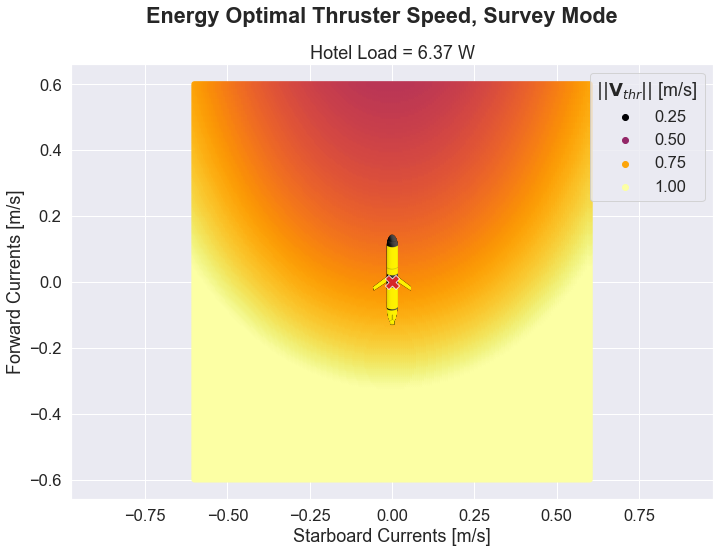

In [141]:
title_name = {
    'v_g' : 'Energy Optimal Thruster Speed, Survey Mode',
    'v_f' : 'Forward Component of Optimal Velocity [m/s]',
    'v_s' : 'Starboard Component of Optimal Velocity [m/s]',
    'v_t' : 'Total Forward Velocity [m/s]',
    'r'   : 'Range in Forward Direction [km]',
    'v_n_r' : 'Range in Forward Direction with Constant Velocity [km]',
    'v_n_d' : 'Range Increase between Optimal and Naive Velocities [km]',
    'v_n_i' : 'Range Increase between Optimal and Naive Velocities [%]',
}
save_name = {
    'v_g' : '/Users/zduguid/Desktop/fig/0-velocity-magnitude.png',
    'v_f' : '/Users/zduguid/Desktop/fig/1-velocity-forward.png',
    'v_s' : '/Users/zduguid/Desktop/fig/2-velocity-starboard.png',
    'v_t' : '/Users/zduguid/Desktop/fig/3-velocity-total.png',
    'r'   : '/Users/zduguid/Desktop/fig/4-range.png',
    'v_n_r' : '/Users/zduguid/Desktop/fig/5-naive-range.png',
    'v_n_d' : '/Users/zduguid/Desktop/fig/6-range-improvement.png',
    'v_n_i' : '/Users/zduguid/Desktop/fig/7-percent-improvement.png',
}

var = 'v_g'

# initialize plot
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(11.5,8))

# plot glider 
glider_im = Image.open('glider.png')
glider_w,glider_h = glider_im.size
glider_AR  = glider_w/glider_h
glider_len = .30
glider_wid =  glider_AR*glider_len
glider_top =  glider_len/2
glider_bot = -glider_len/2
glider_lef = -glider_wid/2
glider_rig =  glider_wid/2
ax.imshow(glider_im, extent=(glider_lef, glider_rig, glider_top, glider_bot), origin='lower', zorder=2)

# plot data 
# test = np.copy(df.v_n_i)
# test[test>0.2] = 0.2
# test*=100
# print(np.max(df[var]))
# TODO -- hacky work-around
df.v_g[200*100+100]=0
# print(np.min(df[var]))
ax.axis('equal')

scatter=sns.scatterplot(
    x=df.c_x, 
    y=df.c_y, 
    hue=df[var],
    palette='inferno',
    linewidth=0,
)

sns.scatterplot(
    x=[0], 
    y=[0], 
    marker='X',
    color='tab:red', 
    s=200,
    zorder=3,
)
ax.axis('equal')
plt.xlabel('Starboard Currents [m/s]')
plt.ylabel('Forward Currents [m/s]')
plt.gca().invert_yaxis()
plt.suptitle(title_name[var], fontweight='bold')
plt.title('Hotel Load = %.2f W' % (hotel))
l_handles, l_labels = ax.get_legend_handles_labels()
# TODO
l_labels = ['v_g', '0.25', '0.50', '0.75', '1.00']
plt.legend(title='$||\mathbf{V}_{thr}||$ [m/s]', labels=l_labels[1:], handles=l_handles[1:])
# plt.savefig(save_name[var])
# plt.ylim(-1,1)
plt.savefig('/Users/zduguid/Desktop/tmp/tmp.png')
# plt.xlim([-0.5,0.5])
# plt.ylim([-0.5,0.5])
plt.axis('equal')
# plt.savefig('/Users/zduguid/Documents/MIT-WHOI/fig/tmp.png')

### Contour Plot

## Determining when DVL Operation is Justified

In [85]:
def get_DVL_energy_consumed(x, y):
    """returns cost in [Whrs/m] when transiting with DVL with the specified ocean current conditions 
    """
    c = np.linalg.norm([x,y])
    d = np.arctan2(x,y)
    r        = 1000
    p_hotel  = 2.00 + 0.37 + 0.40
    E        = 3000
    vtw      = get_opt_v(v_list, c, d, p_hotel, E)
    p_prop   = get_thruster_power(vtw)
    voc_para = c*np.cos(d)
    voc_perp = np.abs(c*np.sin(d))
    
    # get resulting overground velocity 
    vtw_perp = voc_perp
    vtw_para = (vtw**2 - vtw_perp**2)**0.5
    vog_para = vtw_para + voc_para
    
    # mission time and resulting power 
    t          = r/vog_para 
    E_cost     = (p_hotel + p_prop)*t 
    E_avg_cost = E_cost/r
    return(E_avg_cost) 
    
    

def get_no_DVL_energy_consumed(x,y):
    """returns cost in [Whrs/m] when transiting without DVL with the specified ocean current conditions 
    """
    c = np.linalg.norm([x,y])
    d = np.arctan2(x,y)
    r         = 1000
    p_hotel   = 0.37
    E         = 3000
    vtw0      = get_opt_v(v_list, 0, 0, p_hotel, E)
    p_prop0   = get_thruster_power(vtw0)
    voc_para0 = c*np.cos(d)
    voc_perp0 = c*np.sin(d)
    
    # naive travel towards waypoint 
    t0        = r/vtw0
    vog_para0 = vtw0 + voc_para0 
    vog_perp0 = voc_perp0
    
    # find surface location 
    surface_x = vog_perp0*t0
    surface_y = vog_para0*t0
    
    # determine distance remaining
    r1 = np.linalg.norm([surface_x, r-surface_y])
    new_heading = np.arctan2(0-surface_x, r-surface_y)
    
    # new ocean current position 
    c1        = c
    d1        = d - new_heading
    vtw1      = get_opt_v(v_list, c1, d1, p_hotel, E)
    p_prop1   = get_prop_power(vtw1)
    voc_para1 = c1*np.cos(d1)
    voc_perp1 = np.abs(c1*np.sin(d1))

    # get resulting overground velocity 
    vtw_perp1 = voc_perp1
    vtw_para1 = (vtw1**2 - vtw_perp1**2)**0.5
    vog_para1 = vtw_para1 + voc_para1
    
    # mission time and resulting power 
    t1         = r1/vog_para1
    E_cost     = (p_hotel + p_prop0)*t0 + (p_hotel + p_prop1)*t1
    E_avg_cost = E_cost/r
    return(E_avg_cost)

In [86]:
res     = 100
v_max   = 1.0
c_max   = 0.6
v_list  = np.linspace(0, v_max, res)
cx_list = np.linspace(-c_max,c_max,res)
cy_list = np.linspace(-c_max,c_max,res)

opt_noDVL_list = []
opt_DVL_list   = []
opt_c_list     = []
opt_d_list     = []

DVL   = []
noDVL = []

for y in cy_list:
    DVL_row   = []
    noDVL_row = []
    for x in cx_list:
        DVL_row.append(get_DVL_energy_consumed(x,y))
        noDVL_row.append(get_no_DVL_energy_consumed(x,y))
    DVL.append(DVL_row)
    noDVL.append(noDVL_row)

DVL=np.array(DVL)
noDVL=np.array(noDVL)        

In [124]:
2.00 + 0.37 + 0.40

2.77

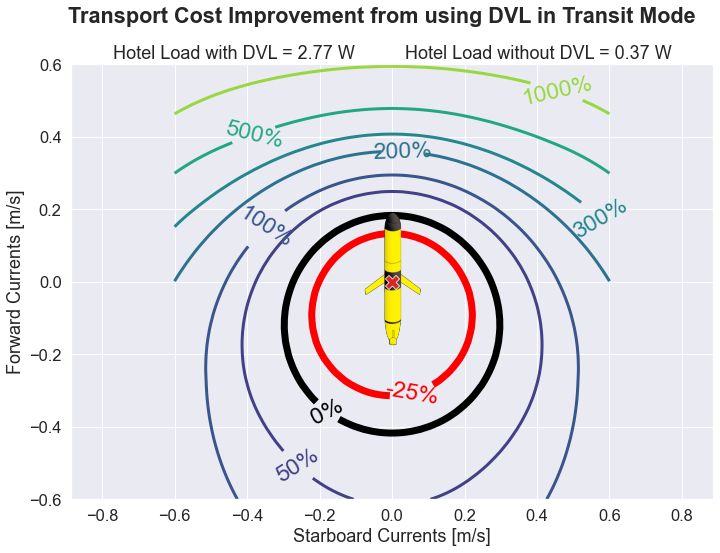

In [138]:
# initialize plot
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(11.5,8))

# plot glider 
glider_im = Image.open('glider.png')
glider_w,glider_h = glider_im.size
glider_AR  = glider_w/glider_h
glider_len = .40
glider_wid =  glider_AR*glider_len
glider_top =  glider_len/2
glider_bot = -glider_len/2
glider_lef = -glider_wid/2
glider_rig =  glider_wid/2
ax.imshow(glider_im, extent=(glider_lef, glider_rig, glider_top, glider_bot), origin='lower', zorder=2)
ax.axis('equal')

levels = [-25, 0, 50, 100, 200, 300, 500, 1000]
widths = [3 for _ in levels]
widths[0] = 7
widths[1] = 7
styles = ['solid' for _ in widths]
styles[1] = 'solid'
styles[0] = 'solid'
colors = plt.cm.viridis(np.abs((np.array(levels)/1400))**0.5)
colors[0] = plt.cm.hsv(0)
colors[1] = plt.cm.gist_gray(0)

CS = ax.contour(
    cx_list, 
    cy_list, 
    ((noDVL/DVL)-1)*100, 
    levels=levels, 
    linewidths=widths, 
    linestyles=styles, 
    vmin=-100, 
    vmax=2000,
    colors=colors
)

ax.clabel(CS, inline=1, fontsize=23, fmt='%d%%')

sns.scatterplot(
    x=[0], 
    y=[0], 
    marker='X',
    color='tab:red', 
    s=200,
    zorder=3,
)
ax.axis('equal')
plt.xlabel('Starboard Currents [m/s]')
plt.ylabel('Forward Currents [m/s]')
plt.gca().invert_yaxis()
# plt.suptitle('Decrease in Transport Cost if DVL used while Transiting', fontweight='bold')
plt.suptitle('Transport Cost Improvement from using DVL in Transit Mode', fontweight='bold')
plt.title('Hotel Load with DVL = %.2f W          Hotel Load without DVL = %.2f W' % (2.77, 0.37))
l_handles, l_labels = ax.get_legend_handles_labels()
plt.savefig('/Users/zduguid/Desktop/tmp/tmp.png')
# plt.savefig('/Users/zduguid/Documents/MIT-WHOI/fig/tmp.png')

---
## Vehicle Design Space Figure

In [ ]:
vehicles = {
    
    'remus' : {
        'range'  : 100,   
        'cost'   : np.NaN, 
        'weight' : 32,     
        'hotel'  : np.NaN, 
        'color'  : 'tab:blue',
    },
    
    
    'spray' : {
        'range'  : 4700,   
        'cost'   : np.NaN, 
        'weight' : 51.8,     
        'hotel'  : np.NaN,    
        'color'  : 'tab:orange',
    },
    
    
    'seaglider': {
        'range'  : 4600,   
        'cost'   : np.NaN, 
        'weight' : 52,     
        'hotel'  : np.NaN,    
        'color'  : 'tab:green',
    },
    
    
    'polarsentinel': {
        'range'  : 5000,   # km
        'cost'   : 150000, # $
        'weight' : 70,     # kg
        'hotel'  : 15,     # W
        'color'  : 'tab:red',
        'image'  : 'img/polarsentinel.png'
    },

    
    'tethys': {
        'range'  : 3000,   
        'cost'   : np.NaN, 
        'weight' : 105,     
        'hotel'  : np.NaN, 
        'color'  : 'tab:purple',
    },
    
    
    'autosub': {
        'range'  : 6000,   
        'cost'   : np.NaN, 
        'weight' : 660,     
        'hotel'  : np.NaN,   
        'color'  : 'tab:pink',
    },
    
    
    'bluefin21' : {
        'range'  : 150,   
        'cost'   : np.NaN, 
        'weight' : 750,     
        'hotel'  : np.NaN,   
        'color'  : 'tab:grey',
    },
    
    
    'sentry': {
        'range'  : 100,   
        'cost'   : np.NaN, 
        'weight' : 1250,     
        'hotel'  : np.NaN,     
        'color'  : 'tab:brown',
    },
    
    
    'theseus' : {
        'range'  : 1500,
        'cost'   : np.NaN,
        'weight' : 8600,
        'hotel'  : np.NaN,
        'color'  : 'tab:cyan',
        'image'  : 'img/theseus.png'
    },
    
    
    'echo-voyager' : {
        'range'  : 12000,
        'cost'   : np.NaN,
        'weight' : 45000,
        'hotel'  : np.NaN,
        'color'  : 'tab:olive',
    },
    
     'test' : {
        'range'  : 20,
        'cost'   : np.NaN,
        'weight' : 8,
        'hotel'  : np.NaN,
        'color'  : 'tab:grey',
    }
}

In [ ]:
# plot glider 
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(15,8))

# vehicle = 'p2'
for vehicle in vehicles:
#     v_im  = Image.open(vehicles[vehicle]['image'])
#     v_w,v_h = v_im.size
    v_range  = vehicles[vehicle]['range']
    v_cost   = vehicles[vehicle]['cost']
    v_weight = vehicles[vehicle]['weight']
    v_hotel  = vehicles[vehicle]['hotel']
    v_color  = vehicles[vehicle]['color']
    sns.scatterplot([v_range], [v_weight], color=v_color, s=100)
#     v_AR  = v_h/v_w
#     v_hgt = v_AR*v_sze
#     v_top = v_hgt/2
#     v_bot = -v_hgt/2
#     v_lef = -v_sze/2
#     v_rig = v_sze/2
#     ax.imshow(v_im, extent=(v_rng+v_lef,v_rng+v_rig,v_wgt+v_top,v_wgt+v_bot), origin='lower', zorder=1)

ax.set(yscale='log', xscale='log')
plt.ylabel('Mass [kg]')
plt.xlabel('Range [km]')
plt.suptitle('Design Space for Arctic sampling AUVs and AUGs', fontweight='bold')
plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
# plt.gca().invert_yaxis()
# plt.ylim(0,10000)
# plt.xlim(0,10000)

In [ ]:
m_dist = [ 6101,  2524,  4913, 2050,  905,  985]

b_time = [327.8, 113.9, 243.0, 97.7, 64.3, 74.8]
b_watt = [  7.9,  16.2,  11.1, 11.1, 16.2, 16.2]

c_time = [142.6,  47.8,  92.2, 40.9, 19.2, 21.6]
c_watt = [ 13.2,  21.6,  16.5, 16.5, 21.6, 21.6]

a_time = [115.0,  45.7,  89.4, 38.0, 17.3, 18.9]
a_watt = [ 15.1,  22.0,  16.8, 17.2, 22.8, 23.0]

def get_transport_economy(minute, watt, distance):
    return (minute*60*watt/distance)

b_econ = np.array([get_transport_economy(b_time[i], b_watt[i], m_dist[i]) for i in range(len(m_dist))])
c_econ = np.array([get_transport_economy(c_time[i], c_watt[i], m_dist[i]) for i in range(len(m_dist))])
a_econ = np.array([get_transport_economy(a_time[i], a_watt[i], m_dist[i]) for i in range(len(m_dist))])

print(b_econ)
print(np.mean(b_econ), np.std(b_econ))
print()
print(c_econ)
print(np.mean(c_econ), np.std(c_econ))
print()
print(a_econ)
print(np.mean(a_econ), np.std(a_econ))

[1.         0.8850141  0.7564708  0.61074042 0.44250705 0.2435292
 0.        ]


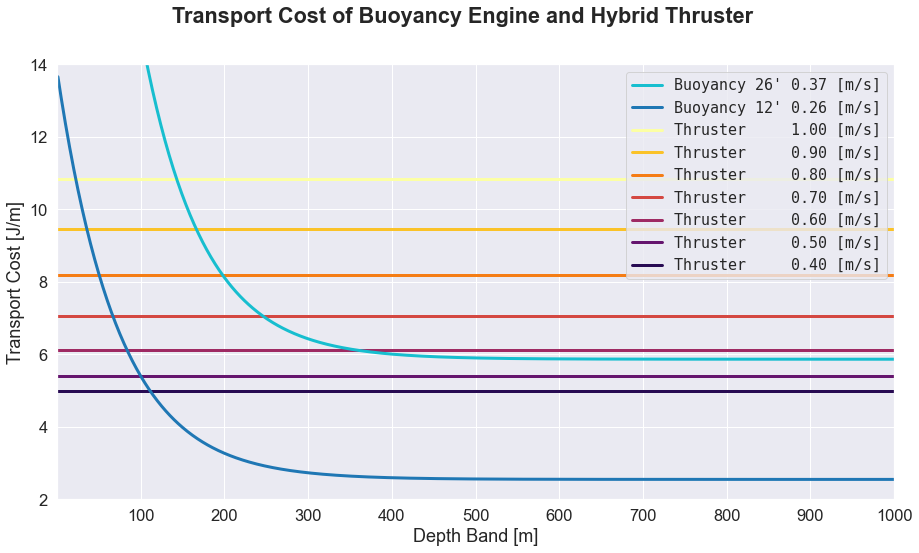

In [48]:
depth_band = np.linspace(1,1000,1001)

def pitch26deg(db):
    """return value in [J/s]"""
    c  = 10.0253
    a  = 0.986224
    b  = 1.62926
    return((c*a**db + b)*3600/1000)

def pitch12deg(db):
    """return value in [J/s]"""
    c  = 3.12918
    a  = 0.986344
    b  = 0.708055
    return((c*a**db + b)*3600/1000)

linewidth = 3


# # original 26deg and 8deg functions 
# def pitch26deg(db):
#     """return value in [J/s]"""
#     c  = 13.3308
#     a  = 0.986228
#     b  = 2.16592
#     return((c*a**db + b)*3600/1000)

# def pitch8deg(db):
#     c  = 3.55734
#     a  = 0.986218
#     b  = 0.770829
#     return((c*a**db + b)*3600/1000)

def hybrid_thruster(v):
    p_thruster = get_thruster_power(v)
    
    # range per day in [m] if traveling at v the whole time 
    range_per_day    = v*24*60*60                     # [m/day]
    metabolic_amps   = 1.64                           # [Ahr/day]
    voltage          = 10.8                           # [Volts]
    metabolic_joules = metabolic_amps*voltage*3600    # [Joules/day]
    metabolic_cost   = metabolic_joules/range_per_day # [Joules/m]
    v_horizontal     = np.cos(26 * np.pi/180)*v
    return(p_thruster/v_horizontal + metabolic_cost)

sns.set(font_scale = 1.5)
fig,ax = plt.subplots(figsize=(15,8))
steep_pitch = [pitch26deg(db) for db in depth_band]
shallow_pitch = [pitch12deg(db) for db in depth_band]

sns.lineplot(depth_band, steep_pitch,   lw=linewidth,   label=r"Buoyancy 26' 0.37 [m/s]",   color="tab:cyan")
sns.lineplot(depth_band, shallow_pitch, lw=linewidth,   label=r"Buoyancy 12' 0.26 [m/s]",   color="tab:blue")


# v_list1 = [1.5, 1.25, 1.0, 0.75, 0.5, 0.25]
# v_list1 = [1.5, 1.3, 1.0, 0.7, 0.4, 0.3, 0.25]

# v_list1 = [1.50, 1.00, 0.50, 0.37, 0.25]
# l_list1 = [1.50, 1.00, 0.50, 0.37, 0.26]

# v_list1 = [1.50, 1.00, 0.50, 0.26]
# l_list1 = [1.50, 1.00, 0.50, 0.26]

v_list1 = [1.00, 0.75, 0.5, 0.37, 0.26]

# v_list1 = list(np.linspace(1,0.01,10))
v_list1 = l = list(np.arange(1,0.37,-0.1))

# colors1 = plt.cm.hot(((np.array(v_list1)-0.05)/2.5))
log_arr = np.log(np.array(v_list1))
log_arr += -np.min(log_arr)
log_arr *= (1/np.max(log_arr))
colors1 = plt.cm.inferno((np.array(v_list1)-0.3)/0.7)

# colors1 = plt.cm.plasma(log_arr)
# colors1 = plt.cm.coolwarm(log_arr)
# colors1 = plt.cm.inferno([1, 0.8, 0.6, 0.4, 0.2])
print(log_arr)
# colors1 = plt.cm.RdYlGn(((np.array(v_list1)-0.2)/1.25))

for i in range(len(v_list1)):
    v = v_list1[i]
    l = v_list1[i]
    c = colors1[i]
    e = hybrid_thruster(v)
    sns.lineplot([0,1000], [e,e], lw=linewidth, color=c, label=r"Thruster     %0.2f [m/s]" % l, zorder=1)

# v_list2 = [0.5, 0.25]
# colors2 = plt.cm.Greens_r(((np.array(v_list2)-0.5)/1.5))
# for i in range(len(v_list2)):
#     v = v_list2[i]
#     c = colors2[i]
#     e = hybrid_thruster(v)
#     sns.lineplot([100,1000], [e,e], lw=3, color=c, label=r"Thruster at %0.2f [m/s]" % v, zorder=1)
#     ax.lines[-1].set_linestyle("--")

leg       = ax.legend(fontsize='small',loc='upper right')
leg_lines = leg.get_lines()
# leg_lines[-1].set_linestyle("--")
# plt.setp(leg.texts, family="Andale Mono")
plt.setp(leg.texts, family="monospace")
# mpl.rc('font',family='Ayuthaya')
plt.ylabel(r"Transport Cost [J/m]")
plt.ylim(2,14)
plt.xlim(0,1000)
plt.xlabel(r"Depth Band [m]")
plt.xticks(range(100,1100,100))
plt.suptitle("Transport Cost of Buoyancy Engine and Hybrid Thruster", fontweight="bold")
plt.savefig('/Users/zduguid/Documents/MIT-WHOI/fig/travel-efficiency.png')

In [44]:
l = list(np.arange(1,0.37,-0.05))
l

[1.0,
 0.95,
 0.8999999999999999,
 0.8499999999999999,
 0.7999999999999998,
 0.7499999999999998,
 0.6999999999999997,
 0.6499999999999997,
 0.5999999999999996,
 0.5499999999999996,
 0.49999999999999956,
 0.4499999999999995,
 0.39999999999999947]

## Kolumbo Speed Control Performance Comparison

In [ ]:
list1 = np.array([54.31, 36.46, 32.79])/(6101) * 3600
list2 = np.array([34.71, 18.87, 18.35])/(2524) * 3600
list3 = np.array([53.63, 28.65, 28.22])/(4913) * 3600
list4 = np.array([21.56, 12.69, 12.25])/(2050) * 3600
list5 = np.array([ 19.61, 7.60 , 7.15])/(905) * 3600
list6 = np.array([ 22.79, 8.53 , 7.92])/(985) * 3600

print(list1)
print(list2)
print(list3)
print(list4)
print(list5)
print(list6)

# Dive B & 2524 & 34.71 & 18.87  & \textbf{18.35} \\ \hline
# Dive C & 4913 & 53.63 & 28.65  & \textbf{28.22} \\ \hline
# Dive D & 2050 & 21.56 & 12.69  & \textbf{12.25} \\ \hline
# Dive E & 905  & 19.61 & 7.60   & \textbf{7.15}  \\ \hline
# Dive F & 985  & 22.79 & 8.53   & \textbf{7.92}  \\ \hline